<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/de_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#check which GPU is being used:
!nvidia-smi

Sat May 13 11:52:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
repo_dir = '/content/'
!wget -P {repo_dir} https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
style_gan_dir = repo_dir + 'stylegan2-ada-pytorch'
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git {style_gan_dir}

!wget https://github.com/Molten-Ice/de-identification/raw/main/media/test_image.jpg

!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.8
    Uninstalling imageio-ffmpeg-0.4.8:
      Successfully uninstalled imageio-ffmpeg-0.4.8
--2023-05-13 11:52:22--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.222.139.28, 52.222.139.100, 52.222.139.123, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.222.139.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘/content/ffhq.pkl’

ffhq.pkl            100%[========

In [3]:
import cv2
import torch
import pickle
import torchvision
import numpy as np
from PIL import Image, ImageOps
from facenet_pytorch import MTCNN

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, repo_dir + 'stylegan2-ada-pytorch')
import dnnlib
import torch_utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)  # torch.nn.Module
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

#I think all losses are negative. The closer to 0 it is the worse it performs.
# e.g. -0.03 is random noise, -1.8 is a generated img

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [55]:
## Imports ##
import os
import cv2
import time
import math
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms

### Helper functions ###

def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    if all_boxes is None: return [], [], []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    # print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs

def calculate_rotate_angle(left_eye, right_eye):

    if left_eye[1] > right_eye[1]: # right eye higher than left eye
        # print("rotating clockwise")
        direction = -1
        third_point = (right_eye[0], left_eye[1])
    else:
        # print("rotating counter-clockwise")
        direction = 1
        third_point = (left_eye[0], right_eye[1])

    def euclidean_distance(a, b):
        return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    a = euclidean_distance(left_eye, third_point)
    b = euclidean_distance(right_eye, left_eye)
    c = euclidean_distance(right_eye, third_point)
    angle = np.degrees(np.arccos((b*b + c*c - a*a)/(2*b*c)))

    if direction == -1:
        angle = 90 - angle

    rotate_angle = direction * angle
    return rotate_angle

def find_new_bbox_cords(mtcnn, rotated_img, face_centre, device):
    new_boxes, _, _ = generate_boxes_landmarks(rotated_img, mtcnn, device)
    boxes_distances = []
    for new_box in new_boxes:
        centre = [(new_box[0] + new_box[2])//2, (new_box[1] + new_box[3])//2]
        difference = abs(np.array(centre) - np.array(face_centre)).mean()
        boxes_distances.append([difference, new_box])
    if len(boxes_distances) == 0: 
        return []
    boxes_distances.sort(key=lambda x: x[0])
    wanted_box = boxes_distances[0][1]
    return wanted_box

def poisson_blend(paste_image, source_img, box):
    """ Poisson blending using seamlessClone
    blends paste_image into source_image
    """
    src_mask = np.zeros(paste_image.shape, paste_image.dtype)
    height,width = paste_image.shape[:2]

    rectangle = np.array([
        [0, 0], 
        [0, height],
        [width, height],
        [width, 0]], np.int32)
    cv2.fillPoly(src_mask, [rectangle], (255, 255, 255))

    box_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    blended = cv2.seamlessClone(paste_image, source_img, src_mask, box_centre, cv2.NORMAL_CLONE)
    return blended

##### Inpainting #####

def train(fixed_noise, cropped_real_face_tensor, mask, lr = 0.0003, iterations = 1500, lam = 0.1, eval_interval = 50):

    #lam is perceptual_loss factor
    progress = []
    fixed_noise = fixed_noise.clone().requires_grad_(True)

    # criterion = nn.BCELoss()
    optimizer = optim.Adam([fixed_noise], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)
    t_start = time.time()
    for i in range(iterations):
        fake_face = G(fixed_noise, None)
        contextual_loss = nn.functional.l1_loss(mask*fake_face, mask*cropped_real_face_tensor)
        perceptual_loss = D(fake_face, None)[0][0] # is unbounded. 0 is a awful prediction, more negative means more confident its a face

        complete_loss = contextual_loss + lam*perceptual_loss

        optimizer.zero_grad()
        complete_loss.backward()
        optimizer.step()
        scheduler.step()

        if i % eval_interval == 0 or i == iterations-1:
            print(f"Losses, {i} iteration:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
            progress.append((cropped_real_face_tensor*mask+fake_face*(1-mask)).cpu())
    return progress

def tensor_to_np(img):
    """Torch tensor -> normalized np image"""
    torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True, padding = 0)
    return np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)

def inpaint(cropped_face, fixed_noise, display_intermediate = False):

    ## Generate image             
    generated_img_tensor = G(fixed_noise, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
    generated_img = tensor_to_np(generated_img_tensor)

    #finds boxes, landmarks using generated image
    generated_boxes, generated_landmarks, generated_probs = generate_boxes_landmarks(generated_img, mtcnn, device)
    #Add loop to create different generated face if this is the case
    assert len(generated_boxes) >=1, "No faces detected in generated image"
    assert len(generated_boxes) == 1, "Two faces detected in generated image"
    box_generated = generated_boxes[0]
    x1, y1, x2, y2 = box_generated
    width = x2 - x1
    height = y2 - y1
    print(f"width: {width}, height: {height}")

    border_factor = 0.15
    tensor_transform = transforms.ToTensor()

    border_width = int(width*border_factor)
    border_height = int(height*border_factor)
    mask = torch.zeros((1, 3, 1024, 1024)).to(device)
    mask[:, :, y1:y2, x1:x2] = 1
    mask[:, :, y1+border_height:y2-border_height, x1+border_width:x2-border_width] = 0

    #convert real face to torch tensor, place aligned with generated face in 1024x1024 square
    resized_face = cv2.resize(cropped_face.copy(), [width, height])
    cropped_real_face_tensor = torch.zeros((1, 3, 1024, 1024)).to(device)
    cropped_real_face_tensor[:, :, y1:y2, x1:x2] = tensor_transform(resized_face).unsqueeze(dim=0).to(device)

    if display_intermediate:
        images_to_concat = []
        for image in [cropped_real_face_tensor, generated_img_tensor, mask,mask*cropped_real_face_tensor, mask*generated_img_tensor, cropped_real_face_tensor*mask+generated_img_tensor*(1-mask)]:
            images_to_concat.append(tensor_to_np(image))
        display_img = np.concatenate(images_to_concat,axis=1)
        display(ImageOps.contain(Image.fromarray(display_img), (1500, 1500)))

    ## Train ##
    progress = train(fixed_noise, cropped_real_face_tensor, mask)

    if display_intermediate:
        images_to_concat = []
        for image in [cropped_real_face_tensor, mask, progress[-1]]:
            images_to_concat.append(tensor_to_np(image))
        display_img = np.concatenate(images_to_concat,axis=1)
        display(ImageOps.contain(Image.fromarray(display_img), (1500, 1500)))

    
    inpainted_faces = []
    for inpainted_face in progress:
        inpainted_face = tensor_to_np(inpainted_face[:, :, y1:y2, x1:x2])
        inpainted_face = cv2.resize(inpainted_face, (cropped_face.shape[1], cropped_face.shape[0]))

        border_width = int(inpainted_face.shape[1]*border_factor)
        border_height = int(inpainted_face.shape[0]*border_factor)
        inpainted_face = inpainted_face[border_height:-border_height, border_width:-border_width]
        inpainted_faces.append(inpainted_face)
    return inpainted_faces

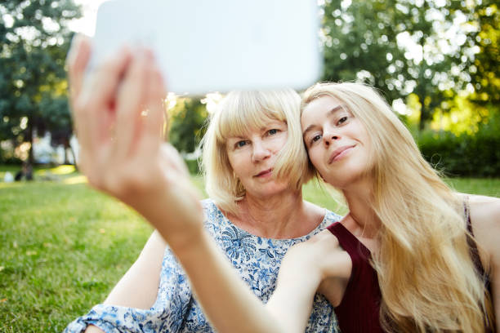

In [52]:
image_filepath = 'test_image.jpg'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load MTCNN face detection model
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
display(ImageOps.contain(Image.fromarray(original_img), (500, 500)))

rotate angle: -35.10 degrees
width: 580, height: 778
Losses, 0 iteration:: Complete:-0.0162, contextual:0.0611, perceptual:-0.0773 (after x0.1), time: 0.07s
Losses, 50 iteration:: Complete:-0.0520, contextual:0.0555, perceptual:-0.1075 (after x0.1), time: 3.33s
Losses, 100 iteration:: Complete:-0.1857, contextual:0.0577, perceptual:-0.2433 (after x0.1), time: 6.85s
Losses, 150 iteration:: Complete:-0.1808, contextual:0.0589, perceptual:-0.2396 (after x0.1), time: 12.36s
Losses, 200 iteration:: Complete:-0.2193, contextual:0.0625, perceptual:-0.2818 (after x0.1), time: 15.91s
Losses, 250 iteration:: Complete:-0.2666, contextual:0.0664, perceptual:-0.3330 (after x0.1), time: 19.67s
Losses, 300 iteration:: Complete:-0.2876, contextual:0.0682, perceptual:-0.3558 (after x0.1), time: 26.01s
Losses, 350 iteration:: Complete:-0.3115, contextual:0.0714, perceptual:-0.3830 (after x0.1), time: 29.79s
Losses, 400 iteration:: Complete:-0.2802, contextual:0.0737, perceptual:-0.3539 (after x0.1), tim

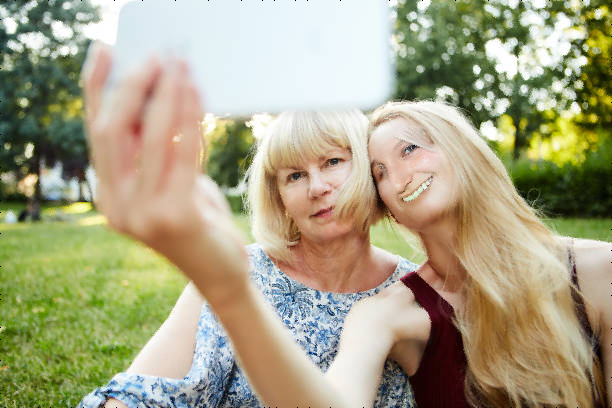

rotate angle: -20.73 degrees
width: 562, height: 721
Losses, 0 iteration:: Complete:0.0995, contextual:0.2212, perceptual:-0.1217 (after x0.1), time: 0.08s
Losses, 50 iteration:: Complete:0.0500, contextual:0.2180, perceptual:-0.1680 (after x0.1), time: 3.43s
Losses, 100 iteration:: Complete:-0.0813, contextual:0.2108, perceptual:-0.2922 (after x0.1), time: 7.35s
Losses, 150 iteration:: Complete:-0.1702, contextual:0.2026, perceptual:-0.3728 (after x0.1), time: 10.71s
Losses, 200 iteration:: Complete:-0.2551, contextual:0.1960, perceptual:-0.4511 (after x0.1), time: 14.06s
Losses, 250 iteration:: Complete:-0.2690, contextual:0.1874, perceptual:-0.4564 (after x0.1), time: 17.43s
Losses, 300 iteration:: Complete:-0.2866, contextual:0.1841, perceptual:-0.4706 (after x0.1), time: 21.20s
Losses, 350 iteration:: Complete:-0.3264, contextual:0.1805, perceptual:-0.5068 (after x0.1), time: 24.48s
Losses, 400 iteration:: Complete:-0.3392, contextual:0.1786, perceptual:-0.5178 (after x0.1), time:

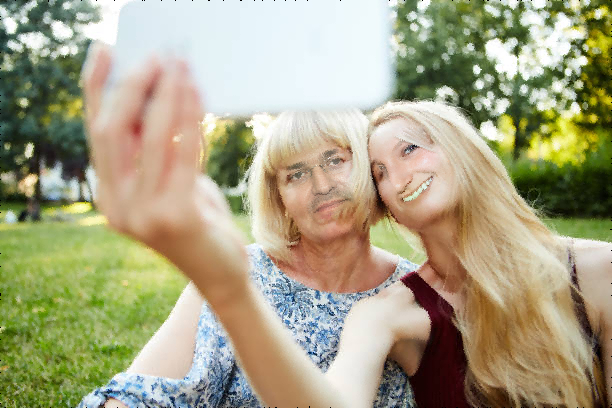

In [54]:
## Looping through each face in the image ##
pad_width = max(original_img.shape[:2])//2

# work with padded image to ensure during rotation the face does not leave the image
original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()

#finds boxes, landmarks using original image
original_boxes, original_landmarks, original_probs = generate_boxes_landmarks(original_img_padded, mtcnn, device)

for box, landmark in zip(original_boxes, original_landmarks):
    left_eye, right_eye = landmark[0], landmark[1]
    face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    print(f"rotate angle: {rotate_angle:.2f} degrees")

    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
    rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre, device)
    cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()
    
    #Inpaint face
    fixed_noise = torch.randn([1, G.z_dim]).to(device) # 512 latent vector     
    inpainted_faces = inpaint(cropped_face, fixed_noise)
    inpainted_face = inpainted_faces[-1]
    #Poisson blend inpainted face onto rotated face
    # rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = inpainted_face.copy() # naive replacement
    blended_img = poisson_blend(inpainted_face.copy(), rotated_img, rotated_box)

    #rotate back to original orientation and set as base image
    unrotated_img = np.array(Image.fromarray(blended_img).rotate(-rotate_angle, center=face_centre, expand=False))
    original_img_padded = unrotated_img
    display(Image.fromarray(original_img_padded[pad_width:-pad_width, pad_width:-pad_width]))

In [47]:
!rm-rf frames
if not os.path.exists("frames"):
    os.makedirs("frames")

inpainted_faces = inpaint(cropped_face)

#place inpaint face back into original image
#Poisson blend inpainted face onto rotated face
# rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = inpainted_face.copy() # naive replacement
for i, inpainted_face in enumerate(inpainted_faces):
    blended_img = poisson_blend(inpainted_face.copy(), rotated_img.copy(), rotated_box)

    #rotate back to original orientation and set as base image
    unrotated_img = np.array(Image.fromarray(blended_img).rotate(-rotate_angle, center=face_centre, expand=False))
    new_img = Image.fromarray(unrotated_img[pad_width:-pad_width, pad_width:-pad_width])
    new_img.save(f"frames/image_{i}.jpg")

display(new_img)

/bin/bash: rm-rf: command not found


In [49]:
!cd frames && ffmpeg -start_number 0 -framerate 5 -i image_%d.jpg \
  -c:v libx264 -pix_fmt yuv420p de-identification-progress.mp4
!mv frames/de-identification-progress.mp4 de-identification-progress.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e